In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime

In [4]:
from bokeh.io import show, output_notebook, curdoc, push_notebook
output_notebook()
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
from bokeh.models import Arrow, VeeHead
from bokeh.plotting import figure
from bokeh.layouts import row, layout, widgetbox, column
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models.widgets import Slider, Select, DateRangeSlider

Loading BokehJS ...

In [26]:
def to_WM(lat, lon):
    '''convert "normal" WGS84 coordinates to the web mercator coordinates that bokeh uses
    code copied from 
    https://gis.stackexchange.com/questions/247871/convert-gps-coordinates-to-web-mercator-epsg3857-using-python-pyproj
    '''
    # derived from the Java version explained here: http://wiki.openstreetmap.org/wiki/Mercator
    RADIUS = 6378137.0 # in meters on the equator

    lat2 = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * RADIUS
    lon2 = np.radians(lon) * RADIUS
    return lat2, lon2

def load_data():
#     data_dir = '../boat/data/'
#     logs = os.listdir(data_dir)
#     dfs= [pd.read_csv(data_dir + fname, sep='\t') for fname in logs]
#     merged = pd.concat(dfs)
    fname = '../pi/data/2018-08-04.csv'
    merged = pd.read_csv(fname, sep='\t')
    
#     convert coords to web mercator projection, which is used by bokeh for plotting
    lat, lon = to_WM(merged['boat_lat'], merged['boat_lon'])
    merged['boat_lat_WM'] = lat
    merged['boat_lon_WM'] = lon
    
    merged = merged.dropna(how='any')
    
#     convert datetime strings into actual datetime objects, then split into two different columns
    merged['datetime'] = pd.to_datetime(merged['datetime'], format="%Y-%m-%d %H:%M:%S")
    merged['date'] = merged['datetime'].apply(lambda datetime: datetime.date())
    merged['time'] = merged['datetime'].apply(lambda datetime: datetime.time())
    merged = merged.sort_values(by='datetime')
    merged = merged.set_index('datetime')
    return merged

merged = load_data()
merged.head()

,boat_COG,boat_lat,boat_lon,boat_speed,pressure,skiff_COG,skiff_lat,skiff_lon,skiff_speed,temp,boat_lat_WM,boat_lon_WM,date,time
datetime,,,,,,,,,,,,,,
2018-08-04 06:08:01,92.242,60.8193,-148.158,0.1306,112.2580,1.683530e-16,1.346820e-34,4.623070e-33,7.502300e-15,2.96000,8.584449e+06,-1.649287e+07,2018-08-04,06:08:01
2018-08-04 06:09:16,95.522,60.8190,-148.157,0.4518,99.2647,2.592300e+02,6.081860e+01,-1.481510e+02,2.400000e-01,3.09260,8.584381e+06,-1.649276e+07,2018-08-04,06:09:16
2018-08-04 06:09:21,85.812,60.8190,-148.157,0.3572,99.2667,2.417660e+02,6.081860e+01,-1.481510e+02,3.500000e-01,3.10429,8.584381e+06,-1.649276e+07,2018-08-04,06:09:21
2018-08-04 06:09:32,88.354,60.8190,-148.157,0.1646,99.2674,2.232800e+02,6.081850e+01,-1.481510e+02,3.960000e-01,3.10819,8.584381e+06,-1.649276e+07,2018-08-04,06:09:32
2018-08-04 06:09:38,87.612,60.8190,-148.157,0.2768,99.2899,2.438460e+02,6.081860e+01,-1.481510e+02,3.740000e-01,3.11209,8.584381e+06,-1.649276e+07,2018-08-04,06:09:38


In [33]:
merged.index.min()

Timestamp('2018-08-04 06:08:01')

In [27]:
def default_map():
#     the bounds of Prince William Sound in WGS coords
    lo_lat, hi_lat, lo_lon, hi_lon = 60, 61.5, -149, -145.5
#     convert to web mercator
    lo_lat, lo_lon = to_WM(lo_lat, lo_lon)
    hi_lat, hi_lon = to_WM(hi_lat, hi_lon)
    p = figure(x_range=(lo_lon, hi_lon), 
           y_range=(lo_lat, hi_lat), 
           x_axis_type="mercator", 
           y_axis_type="mercator",
           tools="pan,wheel_zoom,reset,zoom_in,zoom_out",
           active_scroll='wheel_zoom')
    p.add_tile(CARTODBPOSITRON)
    
    my_hover = HoverTool()
    my_hover.tooltips = [('Time:', '@datetime')]
    p.add_tools(my_hover)
    return p

def draw_boat_COG_arrows(fig, df, color='blue', interval=12):
    i = interval
    for line in df.iterrows():
        i += 1
        if i >= interval:
            hdg = line[1]['boat_COG']
            if np.isfinite(hdg):
                i = 0
                hdg = ((90-hdg) % 360) * (np.pi/180) #convert to traditional math angle
                x,y = line[1]['boat_lon_WM'], line[1]['boat_lat_WM']
                SIGMA = .0000001
                dx = SIGMA*np.cos(hdg)
                dy = SIGMA*np.sin(hdg)
                fig.add_layout(Arrow(end=VeeHead(size=7, 
                                                 fill_color=color,
                                                 line_color=color), 
                                     line_color=color,
                                     x_start=x, 
                                     y_start=y, 
                                     x_end=x+dx, 
                                     y_end=y+dy))

def draw_boat_track(fig, df, color='blue'):
    fig.line(x='boat_lon_WM', y='boat_lat_WM', source=df, color=color)


In [34]:
source = ColumnDataSource(data=merged)
callback = CustomJS(args=dict(source=source), code="""
    console.log("slider changed!")
    //var data = source.data;
    //var f = cb_obj.value
    //var x = data['x']
    //var y = data['y']
    //for (var i = 0; i < x.length; i++) {
    //    y[i] = Math.pow(x[i], f)
    //}
    //source.change.emit();
""")

slider = DateRangeSlider(start=merged.index.min(),
                         end  =merged.index.max(), 
                         value=(merged.index.min(),merged.index.max()),
                         step =1, 
                         title="dates")
slider.js_on_change('value', callback)

def reload_and_show():
    data = load_data()
    m = default_map()
    show(m)
#     draw_boat_track(m, data)
#     draw_boat_COG_arrows(m, data)
#     layout = column(slider, m)

#     return show(layout)

In [35]:
reload_and_show()

ValueError: failed to validate TileRenderer(id='1048', ...).tile_source: expected an instance of type TileSource, got CARTODBPOSITRON of type str

<AxesSubplot:xlabel='boat_COG', ylabel='skiff_COG'>

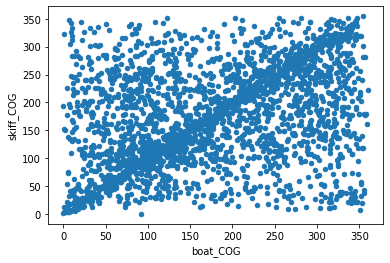

In [38]:
merged.plot.scatter(x='boat_COG', y='skiff_COG')